In [ ]:
%%capture --no-stderr
%pip install -U langchain_google_genai langgraph trustcall langchain_core

In [ ]:
%%capture --no-stderr
%pip install python-dotenv
%pip install langfuse

In [1]:
from langfuse import Langfuse
from langfuse.langchain import CallbackHandler

langfuse = Langfuse(
    public_key="pk-lf-23e53af4-ebcf-40b4-ab28-3f3bc07a0280",
    secret_key="sk-lf-9eab0060-d2a1-43ee-9cec-60192043d47d",
    host="https://cloud.langfuse.com"
)

langfuse_handler = CallbackHandler()

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv

load_dotenv("secrets.env")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

## Visibility into Trustcall updates

Trustcall creates and updates JSON schemas.


In [3]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about cricket.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

We can add a [listener](https://python.langchain.com/docs/how_to/lcel_cheatsheet/#add-lifecycle-listeners) to the Trustcall extractor.

This will pass runs from the extractor's execution to a class, `Spy`, that we will define.

The `Spy` class will extract information about what tool calls were made by Trustcall.

In [4]:
from trustcall import create_extractor
from langchain_google_genai import ChatGoogleGenerativeAI

# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Initialize the spy
spy = Spy()

# Initialize the model
model = ChatGoogleGenerativeAI(model="gemini-2.5-pro",temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Sanath."),
                AIMessage(content="Nice to meet you, sanath."),
                HumanMessage(content="This morning i went for a morning walk in ambekar ground in bangalore.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [6]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (3c535b27-535a-49d6-befa-a4d0c8ddd554)
 Call ID: 3c535b27-535a-49d6-befa-a4d0c8ddd554
  Args:
    content: Sanath went for a morning walk in ambekar ground in bangalore.


In [7]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]:
    print(m)

content='Sanath went for a morning walk in ambekar ground in bangalore.'


In [8]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': '3c535b27-535a-49d6-befa-a4d0c8ddd554'}


In [9]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"),
                        HumanMessage(content="I went to shanti sagar and ate idli and dosa."),
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I am returning to my university in vellore in a new days!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Sanath went for a morning walk in ambekar ground in bangalore.'})]

In [10]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke({"messages": updated_conversation,
                                                        "existing": existing_memories})

In [11]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'baed7706-0b51-4714-977b-cd49a2aa4b5e'}


In [12]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (baed7706-0b51-4714-977b-cd49a2aa4b5e)
 Call ID: baed7706-0b51-4714-977b-cd49a2aa4b5e
  Args:
    content: User is returning to their university in Vellore.


In [13]:
# Parsed responses
for m in result["responses"]:
    print(m)

content='User is returning to their university in Vellore.'


In [14]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'Memory',
   'args': {'content': 'User is returning to their university in Vellore.'},
   'id': 'baed7706-0b51-4714-977b-cd49a2aa4b5e',
   'type': 'tool_call'}]]

In [15]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.

    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []

    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )

    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

New Memory created:
Content: {'content': 'User is returning to their university in Vellore.'}


In [16]:
from typing import TypedDict, Literal

# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

## Graph definition

We add a simple router, `route_message`, that makes a binary decision to save memories.

The memory collection updating is handled by `Trustcall` in the `write_memory` node, as before!

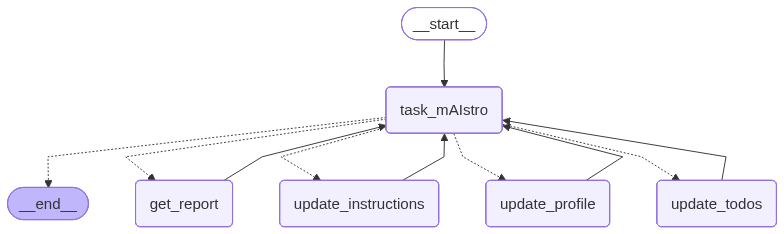

In [55]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize the model
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

class GetToDoReport(TypedDict):
    """ Call this to get a summary report of all current to-do tasks. """
    pass # No arguments needed

# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

"""## Graph definition
"""

# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has",
        default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

# Create the Trustcall extractor for updating the user profile
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# --- Updated system message with reporting instruction ---
# Chatbot instruction for choosing what to update and what tools to call
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot.

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them)
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below.

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. If the user asks for a summary, report, or a list of all their tasks, call the GetToDoReport tool.

6. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction.

Use the provided tools to retain any necessary memories about the user.

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items.

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

# Node definitions
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""

    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    # --- Added GetToDoReport to the list of tools ---
    response = model.bind_tools(
        [UpdateMemory, GetToDoReport], 
        parallel_tool_calls=False
    ).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages,
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()

    # Create the Trustcall extractor for updating the ToDo list
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages,
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")

    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

# --- Node function to get the ToDo report ---
def get_report(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Fetches all to-do items and formats them into a report."""
    
    print("--- FETCHING TO-DO REPORT ---") # For debugging
    
    user_id = config["configurable"]["user_id"]
    namespace = ("todo", user_id)
    
    # Search for all memories in the 'todo' namespace for this user
    memories = store.search(namespace)
    
    if not memories:
        report = "You have no tasks in your ToDo list."
    else:
        report_lines = ["Here is your ToDo report:"]
        for i, mem in enumerate(memories):
            task = mem.value # This is the dict (JSON) from the store
            
            # Safely get values from the task dictionary
            task_name = task.get('task', 'Untitled Task')
            status = task.get('status', 'not started')
            deadline = task.get('deadline', None)
            solutions = task.get('solutions', [])

            report_lines.append(f"\nTask {i+1}: {task_name}")
            report_lines.append(f"  - Status: {status}")
            
            if deadline:
                report_lines.append(f"  - Deadline: {deadline}")
            if solutions:
                report_lines.append(f"  - Solutions: {', '.join(solutions)}")
                
        report = "\n".join(report_lines)
    
    # Get the tool call ID from the last (AIMessage)
    tool_call_id = state['messages'][-1].tool_calls[0]['id']
    
    # Return the report as a ToolMessage
    return {"messages": [{"role": "tool", "content": report, "tool_call_id": tool_call_id}]}


# --- Updated conditional router ---
# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile", "get_report"]:

    """Reflect on the memories and chat history to decide which node to call next."""
    message = state['messages'][-1]
    
    if not message.tool_calls:
        return END
    
    # Get the first tool call
    tool_call = message.tool_calls[0]
    
    if tool_call['name'] == "UpdateMemory":
        args = tool_call['args']
        if args['update_type'] == "user":
            return "update_profile"
        elif args['update_type'] == "todo":
            return "update_todos"
        elif args['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError("Unknown UpdateMemory type")
    
    # Route to the new get_report node
    elif tool_call['name'] == "GetToDoReport":
        return "get_report"

    else:
        # If no recognized tool, end
        return END

# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_node(get_report) # --- Add the report node ---

builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")
builder.add_edge("get_report", "task_mAIstro") # --- Add edge from report back to main ---

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [43]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "sanath"},
         "callbacks": [langfuse_handler]}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is sanath. I live in Bangalore with my fmaily. I have a 15 year old sibling.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is sanath. I live in Bangalore with my fmaily. I have a 15 year old sibling.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (075e6e3d-10e5-4f45-ad22-3fd2e7166d72)
 Call ID: 075e6e3d-10e5-4f45-ad22-3fd2e7166d72
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Hello Sanath! It's nice to know more about you.


In [61]:
# User input for a ToDo
input_messages = [HumanMessage(content="My brother planned to play football today evening.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My brother planned to play football today evening.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (a0cdb74d-3487-41be-b36b-debeee382d97)
 Call ID: a0cdb74d-3487-41be-b36b-debeee382d97
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Okay, thanks for letting me know!


In [56]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (2c523618-afe1-4956-9f80-3c0dd4b33838)
 Call ID: 2c523618-afe1-4956-9f80-3c0dd4b33838
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Okay, I understand. Based on your feedback, your updated instructions for how to update ToDo list items are:

<updated_instructions>
When creating or updating ToDo items, ensure you include specific local businesses / vendors where relevant.
</updated_instructions>


In [46]:
# Check for updated instructions
user_id = "Sanath"

# Search
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

In [47]:
# User input for a ToDo
input_messages = [HumanMessage(content="I need to do dsa for an hour today.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to do dsa for an hour today.
================================== Ai Message ==================================

I've noted that you need to do DSA for an hour today. Could you please specify any local businesses or vendors related to this task, as per your preference?


In [48]:
# Namespace for the memory to save
user_id = "Sanath"

# Search
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

In [49]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the dsa part i need to do it everyday.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the dsa part i need to do it everyday.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (482f89e7-cbc3-4e95-af7f-e188cd817c51)
 Call ID: 482f89e7-cbc3-4e95-af7f-e188cd817c51
  Args:
    update_type: todo
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (26b44499-e30a-4c9f-8d50-42dc185339e1)
 Call ID: 26b44499-e30a-4c9f-8d50-42dc185339e1
  Args:
    update_type: todo
================================== Ai Message ==================================

I've updated your ToDo list to reflect that you need to do DSA for an hour every day. Please remember to include specific local businesses or vendors when creating or updating ToDo items, if applicable.


We can see that Trustcall performs patching of the existing memory:

[Langfuselink]("")

In [59]:
# User input for a ToDo
input_messages = [HumanMessage(content="Need to book flights for my parents to vellore.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Need to book flights for my parents to vellore.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (b547faa4-083e-4876-8a5b-8560c40856bf)
 Call ID: b547faa4-083e-4876-8a5b-8560c40856bf
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'time_to_complete': 60.0, 'solutions': ['Check MakeMyTrip.com', 'Check Goibibo.com', 'Contact local travel agent "Vellore Tours & Travels"'], 'status': 'not started', 'task': 'Book flights for parents to Vellore'}
================================== Ai Message ==================================

I've added "Book flights for parents to Vellore" to your ToDo list. I've also included some potential solutions: "Check MakeMyTrip.com", "Check Goibibo.com", and "Contact local travel agent 'Vellore Tours & Travels'". I've estimated this ta

In [51]:
# Namespace for the memory to save
user_id = "sanath"

# Search
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

Now we can create a new thread.

This creates a new session.

Profile, ToDos, and Instructions saved to long-term memory are accessed.

In [58]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "2", "user_id": "Sanath"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="I have 60 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 60 minutes, what tasks can I get done?
================================== Ai Message ==================================

I can't tell you what tasks you can get done in 60 minutes because I don't have any tasks with time estimates in your ToDo list. Would you like to add some tasks with estimated durations?


In [53]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Yes, give me some options to spend my day.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, give me some options to spend my day.
================================== Ai Message ==================================

Your ToDo list is empty! Please add some tasks, and I can help you prioritize.


In [60]:
# Chat with the chatbot
input_messages = [HumanMessage(content="report.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

report.
================================== Ai Message ==================================
Tool Calls:
  GetToDoReport (743ae7a6-e230-46f9-a556-a411fc437a73)
 Call ID: 743ae7a6-e230-46f9-a556-a411fc437a73
  Args:
--- FETCHING TO-DO REPORT ---
================================= Tool Message =================================

Here is your ToDo report:

Task 1: Book flights for parents to Vellore
  - Status: not started
  - Solutions: Check MakeMyTrip.com, Check Goibibo.com, Contact local travel agent "Vellore Tours & Travels"
================================== Ai Message ==================================

Here is your ToDo report:

Task 1: Book flights for parents to Vellore
  - Status: not started
  - Solutions: Check MakeMyTrip.com, Check Goibibo.com, Contact local travel agent "Vellore Tours & Travels"
